## Laboratorio: Eliminación de anomalías de la imagen

### Integrantes del grupo

- Iván Corrales Solera <ivan.corrales.solera@gmail.com>


## Descripción

El objetivo de este Notebook de Jupyter es mostrar una solución de post procesado de imágenes que nos permita mejorar la calidad de aquellas fotografías que se muestran afectadas por subexposición. La subexposición ocurre cuando el sensor de la cámara no registra ningún detalle en las partes más oscuras de una imagen.

Esta anomalía también llamada **burning**.




### Imágenes utilizadas

Para demostrar la correcta implementación del post procesado usaremos las siguientes fototrafías personales que muestran la anomalía descrita en el apartado anterior. Para demostrar que está anomalía puede darse tanto en espacios abiertos como cerrados utilizaremos 2 fotografías para cada caso:

Tomadas en exterior:

- **Catedral de Berlín**: Hora temprana de la mañana.
- **Río Spree** en Berlín: Un día nublado sin claridad.

Tomadas en interior:

- **Urinarios de campo de concentración de Mauthausen**: Lugar lúgubre con prácticamnete nula iluminación interior, y escasa a través de las ventanas.

- **Restaurante en Peñíscola**: Día soleado de verano desde el interior de un restaurante. 

> Con el propísito de ir aclarando cada uno de los pasos, en este Notebook,  combinaremos pasos de texto con otros de código de python.

## Manos a la obra

Las siguientes librerías serán necesarias para el correcto seguimiento de este Notebook.

- [skimage.io](https://scikit-image.org/): Aunque nos proporciona una gran variedad de operaciones para el tratamiento de fotografía, únicamente la utilizaremos para cargar las imágenes. 
- [matplotlib](https://matplotlib.org/): Librería que nos permite visualizar tanto imágenes como grádicas (por ejemplo los histogramas)
- [numpy](https://numpy.org/): Librería esencial para simplificarnos la ejecución de operaciones matemáticas sobre arrays. 

### Visualización de las imagenes 

Definimos las imagenes en un mapa para poder recorrerlas facilmente cuando queramos operar con ellas. La clave será el título de la imagen.

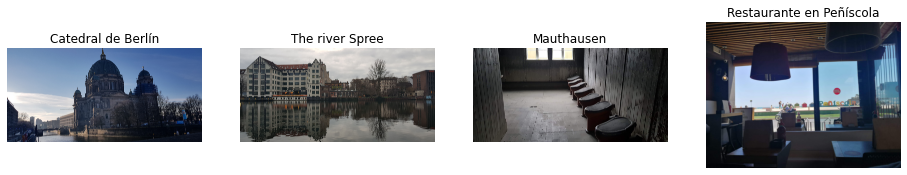

In [6]:
import skimage.io as io
import matplotlib.pyplot as plt

images_path = {
    "Catedral de Berlín": 'images/catedral-Berlin.jpg',
    'The river Spree': 'images/Berlin.jpg',
    "Mauthausen": 'images/mauthausen.jpg',
    'Restaurante en Peñíscola': 'images/peñiscola.jpg',
}
index=0
fig, axes = plt.subplots(ncols=4,figsize=(16,8))
for title,path in images_path.items():
    image = io.imread(path)
    axes[index].set_title(title)
    axes[index].axis('off')
    axes[index].imshow(image)
    index+=1
plt.show()

### Visualización del histograma de las imágenes

Un histograma no es más que la representación gráfica de los pixeles de una fotografía. En el eje horizontal se representa el conjunto de posibles valores que puede tomar cada pixel y en el eje vertical cuántos píxeles hay de dicho valor.

En nuestro caso, dónde los tonos oscuros dominan nuestras fotografías, la forma del histograma se caracterizará por una montaña a la izquierda (zona de tonos oscuros) y huecos a la derecha, pues no hay píxeles que tengan un valor de brillo alto.

A continuación, mostraremos nuestras imágenes junto a 2 representaciones de su histograma:

1. Valores de pixeles entre 0 y 255, siendo 0 el negro absoluto y 255 el color blanco. 

2. Valores de píxeles entre 0 y 3. Esta agrupación nos permitirá apreciar más fácilmente como los pixeles de las fotografías se encuentran hacia la izquierda. 


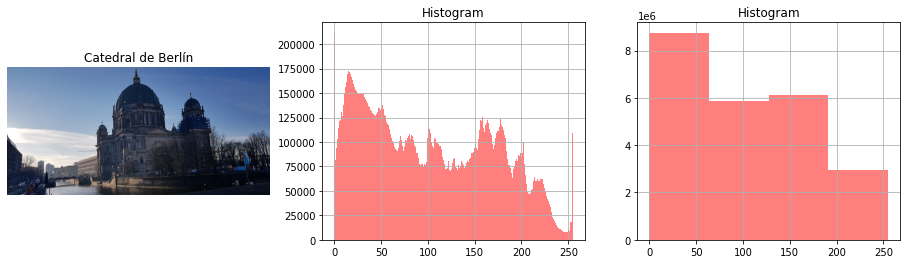

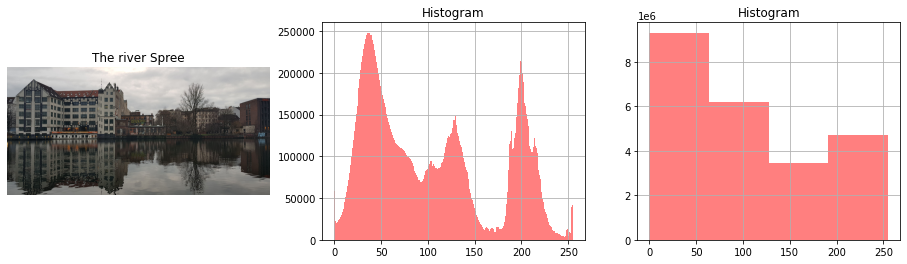

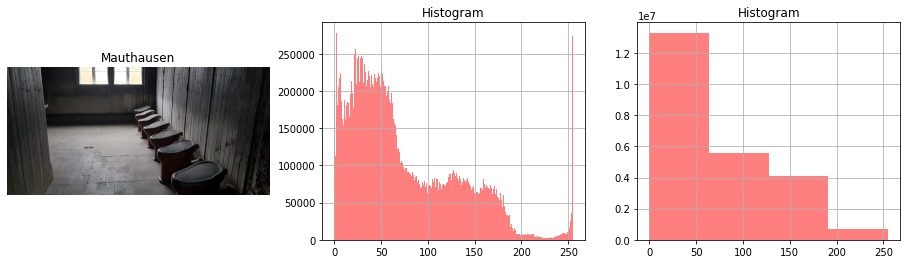

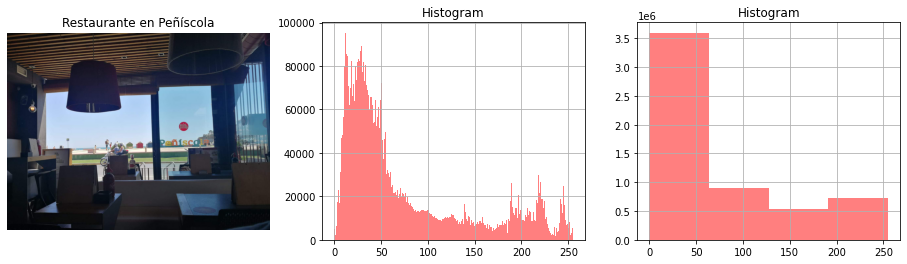

In [7]:
import skimage.io as io
import matplotlib.pyplot as plt

for title, path in images_path.items():
    image = io.imread(path)
    fig, (ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(16,4))
    ax0.set_title(title)
    ax0.axis('off')
    ax0.imshow(image)
    flattened_array = image.ravel()
    ax1.hist(flattened_array, bins = 256, facecolor='red', alpha=0.5)
    ax1.set_title('Histogram')
    ax1.grid(True)
    ax2.hist(flattened_array, bins = 4, facecolor='red', alpha=0.5)
    ax2.set_title('Histogram')
    ax2.grid(True)
    plt.show()

### Procesamiento de imagenes

Para el procesamiento de estas fotografía utilizaremos técnicas de "derecheo", las cuales nos permitirán que en nuestros histogramas dejen de dominar la cantidad de píxeles de tonos oscuros.

#### Transformación logarítmica

Untilizaremos un curva logarítmica que tiene una gran pendiente en áreas con valores de píxel más bajos y una pendiente más pequeña en áreas con valores de píxel más altos. El contraste de las áreas más oscuras mejorará después de que la imagen experimente una transformación logarítmica. Esta transformación se puede utilizar para mejorar los detalles de las partes oscuras de la imagen.

Esta transformación tiene un valor `alpha` (por defecto he decidido que sea 3) que podemos cambiar. Cuanto mayor es su valor los tonos claros abundarán más nuestras imágenes.  

En esta técnica de post procesado se aplicará independientemente de los canales de la imagen (RGB).Esto se debe a que la aplicación de esta transformación logarítmica se efectúa para disminuir los tonos oscuros, independientemente de su color. 

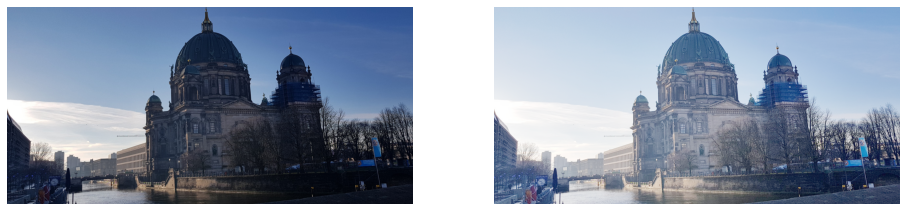

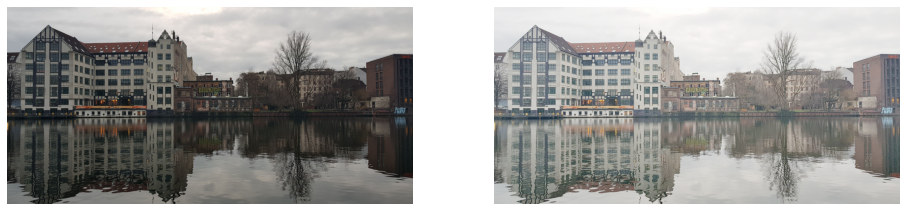

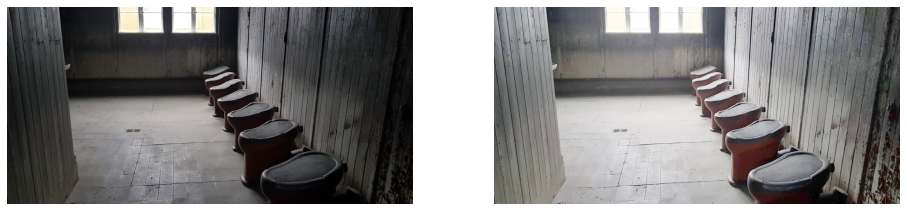

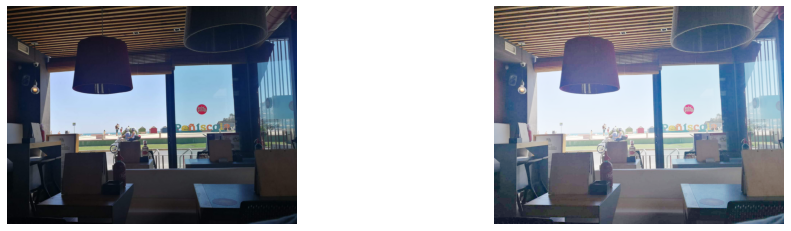

In [8]:
import numpy as np

def transformation_logarithmic_pixel(r, c, factor):
    r= r / 255
    s = c * np.log(1+(factor*r) )
    return s


def transformation_logarithmic(image, alpha=3):
    max_s = 1.
    max_r = image.max() / 255
    factor = np.exp(alpha) - 1
    c = max_s / np.log(1+factor*max_r)
    output = np.array([transformation_logarithmic_pixel(pixel, c, factor) for pixel in image])
    return output.reshape(image.shape)


for title, path in images_path.items():
    image = io.imread(path)
    image_processed = transformation_logarithmic(image)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    ax1.imshow(image)
    ax1.axis('off')
    ax2.imshow(image_processed)
    ax2.axis('off')
    plt.show()


Es evidente la mejora en las fotografías, dónde se observa claramente como los tonos oscuros han desaparecido, permitiéndonos observas los detalles de las fotografías. De todos modos estas imagenes presentan poco contraste, y esto es lo que pretendemos solucionar en el siguiente paso.

#### Filtrado de percentiles

El objetivo de esta transformación es dar a nuestras imágenes el contraste que perdieron (o no tenían) cuando aplicamos la transformación anterior.  Para ello,  realizaremos un filtrado por percentiles. Esta transforamción lo que nos permitirá es distribuir más uniformemente las cantidad de pixeles de cada tonalidad.

A diferencia de la transformación anterior, dónde aplicamos a todos los canales los mismos valores, separaremos los canales de nuestras imágenes y los trataremos de modo independiente. Esto penalizará el tiempo de procesado de nuestras imágenes, pero aplicará una transformaciones consistentes.¡

Existen diferentes teorías sobre los valores de los percentiles a aplicar. Pero al igual que en el caso anterior, donde me arriesgué por un alpha en concreto, en este caso también lo haré. Los percentiles que propongo utilizar son 5% y 95%. 

Esto significa que tomaremos como valores mínimo y máximo los correspondientes a los percentiles del 5% y el 95%. Al operar con estos valores límite, aparecerán valores resultantes fuera del rango de destino, que se igualarán a los valores 0 o 255 (aunque algunos textos recomiendan aproximar estos valores a los valores mínimos y máximo del rango) en función de si se encuentran fuera por el lado negativo o el positivo.

> Esta función tardará más en ejecutarse, porque realizaremos la misma transformación que ya hicimos antes, para comparar como ha evolucionado la calidad de la imagen con los diferentes tratamientos

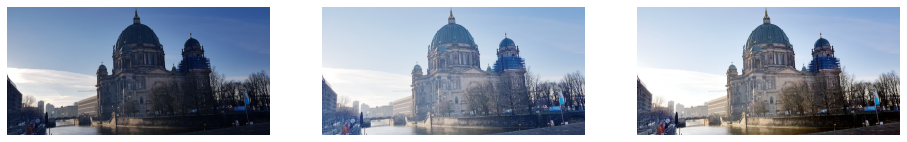

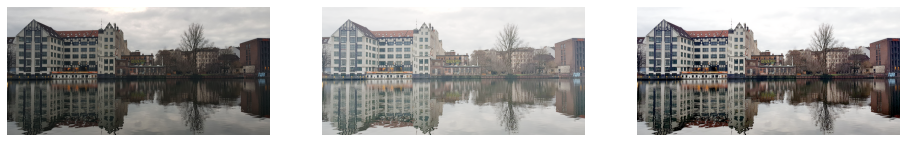

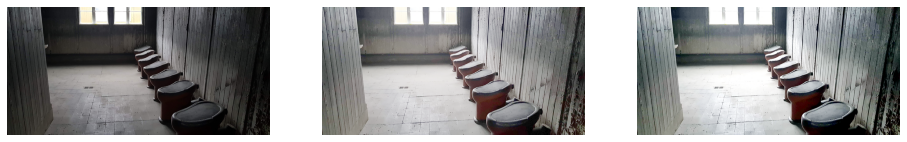

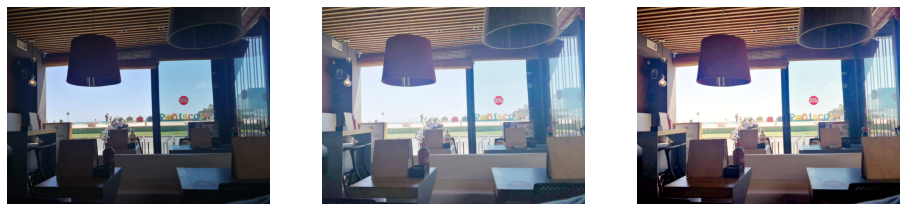

In [9]:
def filtering_percentil_pixels(r, max_r, min_r):
    s = (r-min_r)*255 / (max_r-min_r)
    for i in range (0,len(s)):
        if s[i]<0:
            s[i]=0
        elif s[i]>255:
            s[i]=255
    return s.astype(int)

def filtering_percentil(image, min_percentil=5, max_percentil=95):
    (rows,columns,channels) = image.shape
    output = np.zeros_like(image).astype(int)
    
    min_r, max_r = np.percentile(image[:,:,0], (min_percentil,max_percentil))
    r = np.array([filtering_percentil_pixels(pixels, max_r, min_r) for pixels in image[:,:,0]])
    
    min_r, max_r = np.percentile(image[:,:,1], (min_percentil,max_percentil))
    g = np.array([filtering_percentil_pixels(pixels, max_r, min_r) for pixels in image[:,:,1]])
    
    min_r, max_r = np.percentile(image[:,:,2], (min_percentil,max_percentil))
    b = np.array([filtering_percentil_pixels(pixels, max_r, min_r) for pixels in image[:,:,2]])
 
    return np.dstack((r,g,b))

for title, path in images_path.items():
    image = io.imread(path)
    image_processed = transformation_logarithmic(image)
    image_processed2 = filtering_percentil(image_processed)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    ax1.imshow(image)
    ax1.axis('off')
    ax2.imshow(image_processed)
    ax2.axis('off')
    ax3.imshow(image_processed2)
    ax3.axis('off')
    plt.show()

## Conclusiones

Pese  a que podría haber utilizado librerías existentes que me facilitarían la vida a la hora de transformar nuestras imágenes, he dedidido optar por hacerlo yo con operaciones matemáticas, para un mayor control y aprendizaje de las operaciones realizadas.